## 2 - 使用块的网络
## 2.1 - VGG块

In [6]:
import torch
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size = 3, padding = 1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size = 2, stride = 2))
    return nn.Sequential(*layers)

## 2.2 - VGG网络

In [7]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [8]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    #卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels
    
    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        #全连接层
        nn.Linear(out_channels * 7  * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

In [11]:
X = torch.randn(size = (1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


## 2.3 - 训练模型

In [13]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

training on cuda:0


RuntimeError: CUDA out of memory. Tried to allocate 98.00 MiB (GPU 0; 4.00 GiB total capacity; 972.89 MiB already allocated; 0 bytes free; 976.00 MiB reserved in total by PyTorch)

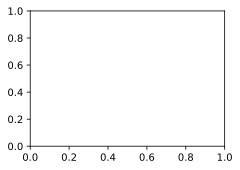

In [14]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize = 224)
train_iter.num_workers = 0
test_iter.num_workers = 0
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())